### Calculate othormetric height using: 
(1) geoid height;    
(2) corrected geoid height (through using spatial variation of ellipsoidal height).   


In [2]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster 


In [3]:
path_lake_vec = 'data/siling_co-lake/hydrolake_siling_co.gpkg'
path_geoid_cor = 'data/siling_co-lake/swot-pixc/raster_height_spavar.nc'
dir_pixc = 'data/siling_co-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
paths_pixc_filtered[0]


'data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_013_217_210L_20240404T082212_20240404T082223_PIC0_01_masked_filtered.nc'

In [4]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
## 2. read corrected geoid data.
raster_height_spavar = xr.open_dataset(path_geoid_cor)
raster_height_spavar

<xarray.Dataset> Size: 142kB
Dimensions:             (x: 160, y: 109)
Coordinates:
  * x                   (x) float64 1kB 88.52 88.53 88.53 ... 89.35 89.36 89.36
  * y                   (y) float64 872B 32.03 32.02 32.02 ... 31.55 31.55 31.54
Data variables:
    ht_spavar_smoothed  (y, x) float64 140kB ...

In [5]:
for path_pixc_filtered in paths_pixc_filtered:
    pixc_filtered = xr.open_dataset(path_pixc_filtered)
    pixc_ht_ds = pixc_filtered[['geoid', 'ht_ortho_filter2']]
    ## 1. extract the pixc corrected geoid from the raster data 
    pixc_ht_spavar = sample_from_raster(
        raster_value = raster_height_spavar.ht_spavar_smoothed.values,
        raster_x = raster_height_spavar.x.values,
        raster_y = raster_height_spavar.y.values,
        points_x = pixc_filtered.longitude.values,
        points_y = pixc_filtered.latitude.values
    )
    pixc_ht_ds = pixc_ht_ds.assign({'ht_spavar': (("points",), pixc_ht_spavar)})
    pixc_ht_ds['ht_spavar'].attrs['description'] = 'spatial variation of lake surface height_ellip'
    ## 2. calculate pixc height with corrected geoid
    geoid_cor = pixc_filtered.geoid.median(dim='points').values + pixc_ht_ds['ht_spavar'].values
    pixc_ht_ortho_cor = pixc_filtered.height.values - geoid_cor
    pixc_ht_ortho_cor[~pixc_filtered['ht_valid_ids'].values] = np.nan   ## mask invalid values
    pixc_ht_ds = pixc_ht_ds.assign({'ht_ortho_cor': (("points",), pixc_ht_ortho_cor)})
    pixc_ht_ds['ht_ortho_cor'].attrs['description'] = 'orthometric height using corrected geoid height'    
    pixc_ht_ds = pixc_ht_ds.rename({'ht_ortho_filter2': 'ht_ortho'})
    pixc_ht_ds['ht_ortho'].attrs['description'] = 'orthometric height (after filtering) using geoid height'
    ### 3. save the pixc heights to a new NetCDF file
    path_pixc_height = path_pixc_filtered.replace('.nc', '_height.nc')
    pixc_ht_ds.to_netcdf(path_pixc_height)
    print(f"Path to save: {path_pixc_height}")


Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_013_217_210L_20240404T082212_20240404T082223_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_015_217_210L_20240516T015222_20240516T015234_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_017_217_210L_20240626T192231_20240626T192243_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_018_217_210L_20240717T160736_20240717T160747_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_020_217_210L_20240828T093745_20240828T093756_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_021_217_210L_20240918T062251_20240918T062302_PIC0_01_masked_filtered_height.nc
Path to save: data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_022_217_210L_20241009T030758_20241009T030809_PIC0_01_masked_filtered_height.nc


Text(0.5, 1.0, 'pixc corrected height_ortho(2024-10-09)')

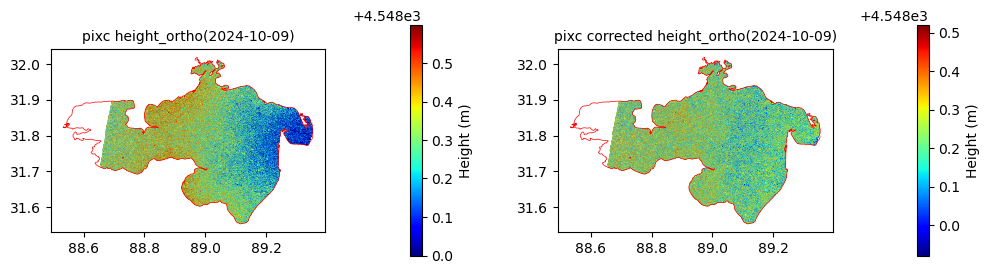

In [6]:
ht_ortho_mean = np.nanmean(pixc_ht_ds.ht_ortho.values)
ht_ortho_cor_mean = np.nanmean(pixc_ht_ds.ht_ortho_cor.values)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
## ax0
scat = ax[0].scatter(x= pixc_ht_ds.longitude, y=pixc_ht_ds.latitude, 
                      c=pixc_ht_ds.ht_ortho.values,
                      vmin=ht_ortho_mean - 0.3,
                      vmax=ht_ortho_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.2)  
ax[0].set_title('pixc height_ortho' + f'({pixc_ht_ds.attrs["date"]})', fontsize=10)
## ax1
scat = ax[1].scatter(x=pixc_ht_ds.longitude, y=pixc_ht_ds.latitude, 
                      c=pixc_ht_ds.ht_ortho_cor.values,
                      vmin=ht_ortho_cor_mean - 0.3,
                      vmax=ht_ortho_cor_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.2)  
ax[1].set_title('pixc corrected height_ortho' + f'({pixc_ht_ds.attrs["date"]})', fontsize=10)


4548.293 4548.218807220459


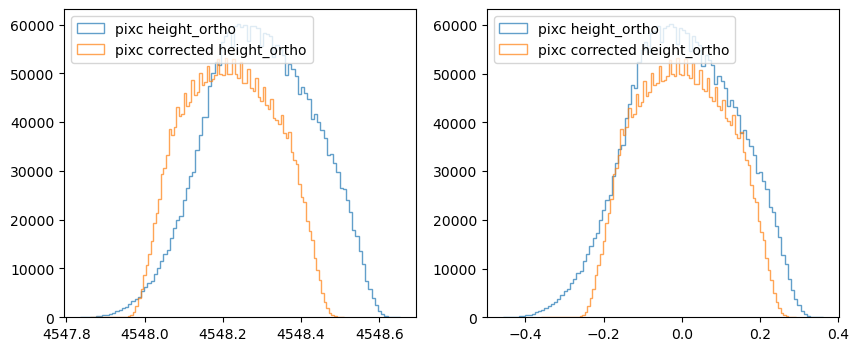

In [7]:
ht_ortho_median = np.nanmedian(pixc_ht_ds.ht_ortho.values)
ht_ortho_cor_median = np.nanmedian(pixc_ht_ds.ht_ortho_cor.values)
print(ht_ortho_median, ht_ortho_cor_median)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(pixc_ht_ds.ht_ortho.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc height_ortho');
ax[0].hist(pixc_ht_ds.ht_ortho_cor.values.ravel(), bins=100, 
                        alpha=0.7, histtype='step', label='pixc corrected height_ortho');
ax[1].hist(pixc_ht_ds.ht_ortho.values.ravel()-ht_ortho_median, bins=100, 
                        alpha=0.7, histtype='step', label='pixc height_ortho');
ax[1].hist(pixc_ht_ds.ht_ortho_cor.values.ravel()-ht_ortho_cor_median, bins=100, 
                        alpha=0.7, histtype='step', label='pixc corrected height_ortho');
ax[0].legend(loc='upper left');
ax[1].legend(loc='upper left');
